In [102]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [103]:
start_date = "2022-08-01"
end_date = "2023-07-31"
data = yf.download("MSFT", start = start_date, end = end_date, auto_adjust=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2022-08-01,274.578907,277.998534,272.621995,274.766693,21539600
2022-08-02,272.780149,274.648114,269.202385,271.613922,22754200
2022-08-03,273.531274,280.192635,273.383000,279.174652,23518900
2022-08-04,278.512458,280.489125,276.901499,280.340881,18098700
2022-08-05,275.893353,280.340854,275.428835,279.609497,16774600


In [104]:
# Keltner Channel
def keltner_channel(data, sp=20, atr=10, factor=2):
    def expmovavg(data):
        return data['Close'].ewm(span=sp, adjust=False).mean()
    
    def get_ATR(data):
        data['H-L'] = data['High'] - data['Low']
        data['H-C'] = abs(data['High'] - data['Close'].shift(1))
        data['C-L'] = abs(data['Close'].shift(1) - data['Low'])
        data['TrueRange'] = data[['H-L', 'H-C', 'C-L']].max(axis=1)
        data['ATR'] = data['TrueRange'].rolling(window=atr).mean()
        return data['ATR']

    EMA = expmovavg(data)
    ATR = get_ATR(data)
    upper_band = EMA + (factor*ATR)
    lower_band = EMA - (factor*ATR)

    return EMA, upper_band, lower_band

In [105]:
EMA, upper_band, lower_band = keltner_channel(data)

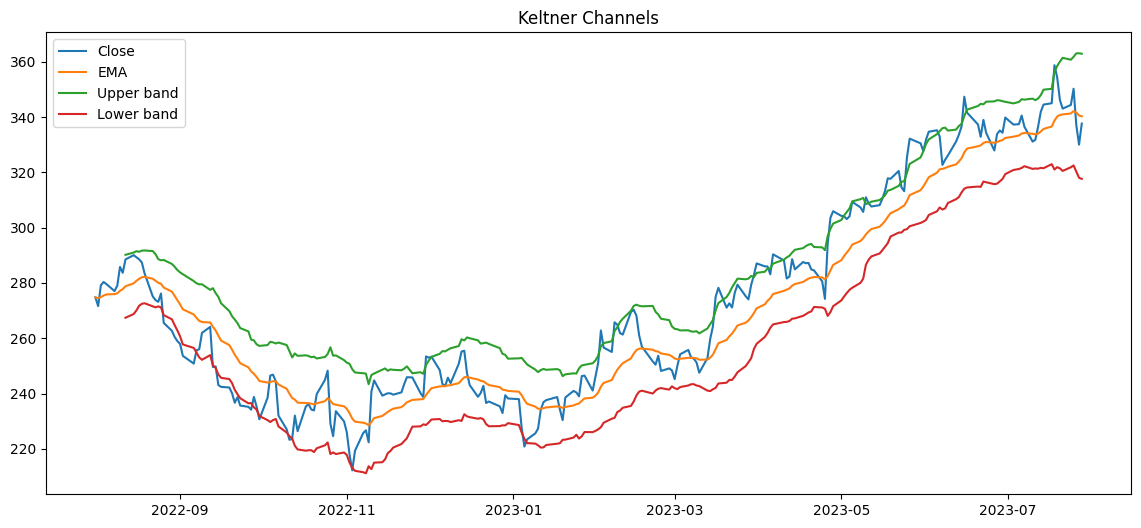

In [106]:
# Keltner Channel Plot
plt.figure(figsize=(14,6))
plt.title('Keltner Channels')
plt.plot(data['Close'], label='Close')
plt.plot(EMA, label='EMA')
plt.plot(upper_band, label='Upper band')
plt.plot(lower_band, label='Lower band')
plt.legend(loc = "upper left", prop = {'size' : 10})

In [107]:
# Candlestick Plot
candlestick = go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close']
    )

layout = go.Layout(
        title='Candlestick Chart Pattern',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price'),
        showlegend=False
    )
fig = go.Figure(data=[candlestick], layout=layout)
fig.update_layout(height=400, width=1500)  # Set the desired chart size
fig.show()

In [108]:
# Keltner Channel and Candlestick
fig.add_trace(candlestick)

fig.add_trace(go.Scatter(
    x=data.index, y=EMA,
    mode='lines',
    name='EMA',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=data.index, y=upper_band,
    mode='lines',
    name='Upper Band',
    line=dict(color='orange')
))
fig.add_trace(go.Scatter(
    x=data.index, y=lower_band,
    mode='lines',
    name='Lower Band',
    line=dict(color='orange')
))

fig.update_layout(
        title='Keltner Channel and Candlestick Chart',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price')
    )

# Show the combined plot
fig.show()

In [109]:
fig = go.Figure()
fig.add_trace(candlestick)

fig.add_trace(go.Scatter(
    x=data.index, y=EMA,
    mode='lines',
    name='EMA',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=data.index, y=upper_band,
    mode='lines',
    name='Upper Band',
    line=dict(color='orange')
))
fig.add_trace(go.Scatter(
    x=data.index, y=lower_band,
    mode='lines',
    name='Lower Band',
    line=dict(color='orange')
))

# Hammer Candlestick
hammer_pattern = data[(data['Open'] - data['Low']) > 2 * (data['Close'] - data['Open'])]

# Shooting Star
shooting_pattern = data[(data['High'] - data['Close']) > 2 * (data['Close'] - data['Open'])]

buy_signals = hammer_pattern['High']
sell_signals = shooting_pattern['Close']

# Buy
fig.add_trace(go.Scatter(
    x=hammer_pattern.index,
    y=buy_signals,
    mode='markers',
    marker=dict(symbol="cross", color="green"),
    name='Buy Signals'
))

# Sell
fig.add_trace(go.Scatter(
    x=shooting_pattern.index,
    y=sell_signals,
    mode='markers',
    marker=dict(symbol="cross", color="red"),
    name='Sell Signals'
))

fig.update_layout(
    title='Keltner Channel and Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    showlegend=True
)

fig.show()

In [110]:
#Returns, Drawdown, and Sharpe Ratio
returns = (hammer_pattern['Close'].pct_change() + 1).cumprod()
cumulative_return = returns[-1] - 1

# Drawdown
equity_curve = returns.cumprod()
previous_peak = equity_curve.cummax()
drawdowns = (equity_curve - previous_peak) / previous_peak
max_drawdown = drawdowns.max()

# Sharpe Ratio
daily_returns = hammer_pattern['Close'].pct_change()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

In [111]:
print("Cumulative Returns: ", cumulative_return)
print("Maximum Drawdown: ", max_drawdown)
print("Sharpe Ratio: ", sharpe_ratio)

Cumulative Returns:  0.20109634472161142
Maximum Drawdown:  0.0
Sharpe Ratio:  1.0052759760832817
